## HCC Survival Classification

The HTML reports for this notebook are available at the below location:  

https://drive.google.com/drive/u/0/folders/1cHSlmb7gQCxUxfZsKhjJlmDpJp6uadXd

In [1]:
import os
os.chdir('D:/TigerML/code_templates-classification-scripts/case_examples/hcc-survival')

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import os
import sys

sys.path.append(os.path.join(os.getcwd(),"../.." ))

from utils import load_yml
import eda
import model_gen
import model_eval
import feature_selection as fs
import data_processing as dp

file_path = 'D:/TigerML/code_templates-classification-scripts/case_examples/hcc-survival/config.yml'

### Config File

dataset : https://archive.ics.uci.edu/ml/machine-learning-databases/00423/hcc-survival.zip   
yml file : Consists of hard coded configuration such as:  
dataset_path - local directory path with data  
estimator_path - local directory with estimators (models and grid search parameters)  
target_column - binary dependent variable column name in dataset.  
train_ratio - train and testing dataset split ratio for model building.  
drop_cols - columns / variables to remove from datatset.  
numeric_impute and categorical_impute  
fs - feature selection type (recursion - sklearn feature selection / fs - mlxtend feature selection)  
fs_params - parameters related to feature selection model  

In [3]:
config_file = load_yml(file_path)
print(config_file)

{'dataset_path': 'D:/TigerML/code_templates-classification-scripts/hcc-data.txt', 'estimator_config_path': 'D:/TigerML/code_templates-classification-scripts/case_examples/hcc-survival/estimators.yml', 'target_column': 'Class Attribute', 'output_path': 'D:/TigerML/code_templates-classification-scripts/case_examples/hcc-survival/model_output.csv', 'train_ratio': 0.8, 'seed': 13, 'drop_cols': [], 'numeric_impute': 'mean', 'categorical_impute': 'mode', 'fs': 'recursion', 'feature_selection': {'regularization': {'estimator': 'sklearn.linear_model.Ridge', 'estimator_params': {'alpha': 0.5}}, 'recursion': {'estimator': 'sklearn.linear_model.Ridge', 'estimator_params': {'alpha': 0.5}, 'fs_params': {'forward': False, 'verbose': False, 'k_features': 'best'}}}}


### Loading Data

In [4]:
df_data = pd.read_csv(config_file['dataset_path'],sep=',',header=None)
header = ['Gender','Symptoms ','Alcohol','Hepatitis B Surface Antigen','Hepatitis B e Antigen','Hepatitis B Core Antibody','Hepatitis C Virus Antibody','Cirrhosis','Endemic Countries','Smoking','Diabetes','Obesity','Hemochromatosis','Arterial Hypertension','Chronic Renal Insufficiency','Human Immunodeficiency Virus','Nonalcoholic Steatohepatitis','Esophageal Varices','Splenomegaly','Portal Hypertension','Portal Vein Thrombosis','Liver Metastasis','Radiological Hallmark','Age at diagnosis','Grams of Alcohol per day','Packs of cigarets per year','Performance Status*','Encephalopathy degree*','Ascites degree*','International Normalised Ratio*','Alpha-Fetoprotein (ng/mL)','Haemoglobin (g/dL)','Mean Corpuscular Volume','Leukocytes(G/L)','Platelets','Albumin (mg/dL)','Total Bilirubin(mg/dL)','Alanine transaminase (U/L)','Aspartate transaminase (U/L)','Gamma glutamyl transferase (U/L)','Alkaline phosphatase (U/L)','Total Proteins (g/dL)','Creatinine (mg/dL)','Number of Nodules','Major dimension of nodule (cm)','Direct Bilirubin (mg/dL)','Iron','Oxygen Saturation (%)','Ferritin (ng/mL)','Class Attribute']
df_data.columns =  header
df_data

Gender Symptoms   Alcohol Hepatitis B Surface Antigen  \
0         1         0        1                           0   
1         0         ?        0                           0   
2         1         0        1                           1   
3         1         1        1                           0   
4         1         1        1                           1   
..      ...       ...      ...                         ...   
160       0         0        1                           ?   
161       0         1        0                           ?   
162       1         0        1                           0   
163       1         0        1                           1   
164       1         1        1                           0   

    Hepatitis B e Antigen Hepatitis B Core Antibody  \
0                       0                         0   
1                       0                         0   
2                       0                         1   
3                       0                         0   
4                       0                         1   
..                    ...                       ...   
160                     ?                         ?   
161                     ?                         ?   
162                     0                         0   
163                     0                         1   
164                     0                         0   

    Hepatitis C Virus Antibody  Cirrhosis Endemic Countries Smoking  ...  \
0                            0          1                 0       1  ...   
1                            1          1                 ?       ?  ...   
2                            0          1                 0       1  ...   
3                            0          1                 0       1  ...   
4                            0          1                 0       1  ...   
..                         ...        ...               ...     ...  ...   
160                          1          1                 0       1  ...   
161                          ?          1                 0       0  ...   
162                          0          1                 0       1  ...   
163                          1          1                 1       1  ...   
164                          1          1                 0       1  ...   

    Alkaline phosphatase (U/L) Total Proteins (g/dL) Creatinine (mg/dL)  \
0                          150                   7.1                0.7   
1                            ?                     ?                  ?   
2                          109                     7                2.1   
3                          174                   8.1               1.11   
4                          109                   6.9                1.8   
..                         ...                   ...                ...   
160                        109                   7.6                0.7   
161                        280                   6.7                0.7   
162                        181                   7.5               1.46   
163                        170                   8.4               0.74   
164                        462                   6.6               3.95   

    Number of Nodules Major dimension of nodule (cm) Direct Bilirubin (mg/dL)  \
0                   1                            3.5                      0.5   
1                   1                            1.8                        ?   
2                   5                             13                      0.1   
3                   2                           15.7                      0.2   
4                   1                              9                        ?   
..                ...                            ...                      ...   
160                 5                              3                        ?   
161                 1                            2.2                      2.3   
162                 5                           18.6    

**Nominal:**  
Gender  
Symptoms  
Alcohol  
Hepatitis B Surface Antigen  
Hepatitis B e Antigen  
Hepatitis B Core Antibody  
Hepatitis C Virus Antibody  
Cirrhosis   
Endemic Countries  
Smoking  
Diabetes  
Obesity  
Hemochromatosis  
Arterial Hypertension  
Chronic Renal Insufficiency  
Human Immunodeficiency Virus  
Nonalcoholic Steatohepatitis  
Esophageal Varices  
Splenomegaly  
Portal Hypertension  
Portal Vein Thrombosis  
Liver Metastasis  
Radiological Hallmark  

**Continuous:**  

Grams of Alcohol per day  
Packs of cigarets per year   
Performance Status: ordinal  
Encefalopathy degree: ordinal   
Ascites degree: ordinal  
International Normalised Ratio   
Alpha-Fetoprotein (ng/mL)   
Haemoglobin (g/dL)   
Mean Corpuscular Volume (fl)
Leukocytes(G/L)   
Platelets (G/L)  
Albumin (mg/dL)   
Total Bilirubin(mg/dL)  
Alanine transaminase (U/L)  
Aspartate transaminase (U/L)   
Gamma glutamyl transferase (U/L)   
Alkaline phosphatase (U/L)   
Total Proteins (g/dL)  
Creatinine (mg/dL)  
Number of Nodules: integer   
Major dimension of nodule (cm)   
Direct Bilirubin (mg/dL)   
Iron (mcg/dL)   
Oxygen Saturation (%)   
Ferritin (ng/mL)   
Class Attribute(1 if patient survives, 0 if patient died)   

**Integer:**  

Age at diagnosis   

#### Data Exploration

In [5]:
df_data.head()
#df_data.tail()

Gender Symptoms   Alcohol Hepatitis B Surface Antigen  \
0       1         0        1                           0   
1       0         ?        0                           0   
2       1         0        1                           1   
3       1         1        1                           0   
4       1         1        1                           1   

  Hepatitis B e Antigen Hepatitis B Core Antibody Hepatitis C Virus Antibody  \
0                     0                         0                          0   
1                     0                         0                          1   
2                     0                         1                          0   
3                     0                         0                          0   
4                     0                         1                          0   

   Cirrhosis Endemic Countries Smoking  ... Alkaline phosphatase (U/L)  \
0          1                 0       1  ...                        150   
1          1                 ?       ?  ...                          ?   
2          1                 0       1  ...                        109   
3          1                 0       1  ...                        174   
4          1                 0       1  ...                        109   

  Total Proteins (g/dL) Creatinine (mg/dL) Number of Nodules  \
0                   7.1                0.7                 1   
1                     ?                  ?                 1   
2                     7                2.1                 5   
3                   8.1               1.11                 2   
4                   6.9                1.8                 1   

  Major dimension of nodule (cm) Direct Bilirubin (mg/dL) Iron  \
0                            3.5                      0.5    ?   
1                            1.8                        ?    ?   
2                             13                      0.1   28   
3                           15.7                      0.2    ?   
4                              9                        ?   59   

  Oxygen Saturation (%) Ferritin (ng/mL) Class Attribute  
0                     ?                ?               1  
1                     ?                ?               1  
2                     6               16               1  
3                     ?                ?               0  
4                    15               22               1  

[5 rows x 50 columns]

In [6]:
df_data.dtypes

Gender                               int64
Symptoms                            object
Alcohol                              int64
Hepatitis B Surface Antigen         object
Hepatitis B e Antigen               object
Hepatitis B Core Antibody           object
Hepatitis C Virus Antibody          object
Cirrhosis                            int64
Endemic Countries                   object
Smoking                             object
Diabetes                            object
Obesity                             object
Hemochromatosis                     object
Arterial Hypertension               object
Chronic Renal Insufficiency         object
Human Immunodeficiency Virus        object
Nonalcoholic Steatohepatitis        object
Esophageal Varices                  object
Splenomegaly                        object
Portal Hypertension                 object
Portal Vein Thrombosis              object
Liver Metastasis                    object
Radiological Hallmark               object
Age at diag

#### We will convert the pandas dataframe to Analyser class of TigerML for further analysis

In [7]:
an = eda.Analyser(data = df_data)
an.variable_summary()

Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds


Replacing '?' with NaN

In [8]:
df_data=df_data.replace('?',np.NaN)

Cleaning column names

In [9]:
df_data.columns = df_data.columns.str.replace('*','')

Converting columns to correct data types

In [10]:
lst = ['Gender', 'Symptoms ', 'Alcohol', 'Hepatitis B Surface Antigen',
       'Hepatitis B e Antigen', 'Hepatitis B Core Antibody',
       'Hepatitis C Virus Antibody', 'Cirrhosis', 'Endemic Countries',
       'Smoking', 'Diabetes', 'Obesity', 'Hemochromatosis',
       'Arterial Hypertension', 'Chronic Renal Insufficiency',
       'Human Immunodeficiency Virus', 'Nonalcoholic Steatohepatitis',
       'Esophageal Varices', 'Splenomegaly', 'Portal Hypertension',
       'Portal Vein Thrombosis', 'Liver Metastasis',
       'Radiological Hallmark','Encephalopathy degree','Ascites degree','Performance Status','Number of Nodules']
df_data[lst] = df_data[lst].astype(str)

lst = ['Grams of Alcohol per day', 'Packs of cigarets per year',
       'International Normalised Ratio', 'Alpha-Fetoprotein (ng/mL)',
       'Haemoglobin (g/dL)', 'Mean Corpuscular Volume', 'Leukocytes(G/L)',
       'Platelets', 'Albumin (mg/dL)', 'Total Bilirubin(mg/dL)',
       'Alanine transaminase (U/L)', 'Aspartate transaminase (U/L)',
       'Gamma glutamyl transferase (U/L)', 'Alkaline phosphatase (U/L)',
       'Total Proteins (g/dL)', 'Creatinine (mg/dL)', 'Number of Nodules',
       'Major dimension of nodule (cm)', 'Direct Bilirubin (mg/dL)',
       'Iron', 'Oxygen Saturation (%)', 'Ferritin (ng/mL)']
df_data[lst] = df_data[lst].astype(float)

df_data[config_file['target_column']]=df_data[config_file['target_column']].astype(int)

#### Target variable summary

In [11]:
df_data[config_file['target_column']].value_counts(normalize = True)


1    0.618182
0    0.381818
Name: Class Attribute, dtype: float64

#### Data Preprocessing
##### Converting '?' present in the data to NaN

In [12]:
df_data.isna().sum()

Gender                               0
Symptoms                             0
Alcohol                              0
Hepatitis B Surface Antigen          0
Hepatitis B e Antigen                0
Hepatitis B Core Antibody            0
Hepatitis C Virus Antibody           0
Cirrhosis                            0
Endemic Countries                    0
Smoking                              0
Diabetes                             0
Obesity                              0
Hemochromatosis                      0
Arterial Hypertension                0
Chronic Renal Insufficiency          0
Human Immunodeficiency Virus         0
Nonalcoholic Steatohepatitis         0
Esophageal Varices                   0
Splenomegaly                         0
Portal Hypertension                  0
Portal Vein Thrombosis               0
Liver Metastasis                     0
Radiological Hallmark                0
Age at diagnosis                     0
Grams of Alcohol per day            48
Packs of cigarets per yea

### Analyser for EDA

In [13]:
an = eda.Analyser(data = df_data,y=config_file['target_column'])

Started running health_analysis
Started running data_health
Started running duplicate_columns
processing set of - ['Symptoms ', 'Hepatitis B Surface Antigen', 'Hepatitis B e Antigen', 'Hepatitis B Core Antibody', 'Hepatitis C Virus Antibody', 'Endemic Countries', 'Arterial Hypertension', 'Chronic Renal Insufficiency', 'Human Immunodeficiency Virus', 'Nonalcoholic Steatohepatitis', 'Splenomegaly', 'Portal Hypertension', 'Portal Vein Thrombosis', 'Liver Metastasis', 'Performance Status']
processing set of - ['Gender', 'Alcohol', 'Cirrhosis', 'Smoking', 'Diabetes', 'Hemochromatosis', 'Esophageal Varices', 'Radiological Hallmark', 'Encephalopathy degree', 'Ascites degree']
Finished running duplicate_columns
Time taken to run duplicate_columns is 0 seconds
Finished running data_health
Time taken to run data_health is 0 seconds
Started running missing_plot
Finished running missing_plot
Time taken to run missing_plot is 0 seconds
Started running missing_value_summary
Finished running missing_

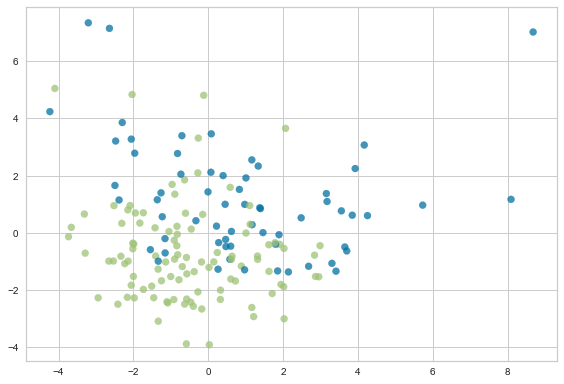

In [14]:
eda.perform_eda(df_data, config_file['target_column'])

In [15]:
an.missing_value_summary()

Started running missing_value_summary
Finished running missing_value_summary
Time taken to run missing_value_summary is 0 seconds


'No Missing Values'

In [16]:
df_data[df_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [Gender, Symptoms , Alcohol, Hepatitis B Surface Antigen, Hepatitis B e Antigen, Hepatitis B Core Antibody, Hepatitis C Virus Antibody, Cirrhosis, Endemic Countries, Smoking, Diabetes, Obesity, Hemochromatosis, Arterial Hypertension, Chronic Renal Insufficiency, Human Immunodeficiency Virus, Nonalcoholic Steatohepatitis, Esophageal Varices, Splenomegaly, Portal Hypertension, Portal Vein Thrombosis, Liver Metastasis, Radiological Hallmark, Age at diagnosis, Grams of Alcohol per day, Packs of cigarets per year, Performance Status, Encephalopathy degree, Ascites degree, International Normalised Ratio, Alpha-Fetoprotein (ng/mL), Haemoglobin (g/dL), Mean Corpuscular Volume, Leukocytes(G/L), Platelets, Albumin (mg/dL), Total Bilirubin(mg/dL), Alanine transaminase (U/L), Aspartate transaminase (U/L), Gamma glutamyl transferase (U/L), Alkaline phosphatase (U/L), Total Proteins (g/dL), Creatinine (mg/dL), Number of Nodules, Major dimension of nodule (cm), Direct Bilirubin (mg/dL), Iron, Oxygen Saturation (%), Ferritin (ng/mL), Class Attribute]
Index: []

[0 rows x 50 columns]

In [17]:
an.missing_plot()

Started running missing_plot
Finished running missing_plot
Time taken to run missing_plot is 0 seconds


:Bars   [index]   (0)

##### Columns with >40% missing values are removed
##### Imputing mean for numeric columns and mode in the case of categorical columns (or binary)

In [18]:
#removing variables with 40% missing values
df_data.drop(['Oxygen Saturation (%)','Ferritin (ng/mL)'],axis=1,inplace=True)
df_data = dp.Imputer(df_data, num_impute_method = config_file['numeric_impute'],cat_impute_method=config_file['categorical_impute']).transform()


##### Check

In [19]:
df_data.isna().sum()

Gender                              0
Symptoms                            0
Alcohol                             0
Hepatitis B Surface Antigen         0
Hepatitis B e Antigen               0
Hepatitis B Core Antibody           0
Hepatitis C Virus Antibody          0
Cirrhosis                           0
Endemic Countries                   0
Smoking                             0
Diabetes                            0
Obesity                             0
Hemochromatosis                     0
Arterial Hypertension               0
Chronic Renal Insufficiency         0
Human Immunodeficiency Virus        0
Nonalcoholic Steatohepatitis        0
Esophageal Varices                  0
Splenomegaly                        0
Portal Hypertension                 0
Portal Vein Thrombosis              0
Liver Metastasis                    0
Radiological Hallmark               0
Age at diagnosis                    0
Grams of Alcohol per day            0
Packs of cigarets per year          0
Performance 

### Outliers

In [20]:
an.get_outliers_df().reset_index()

feature  < (mean-3*std)  > (mean+3*std)  \
0                   Age at diagnosis               2               0   
1         Alanine transaminase (U/L)               0               3   
2         Alkaline phosphatase (U/L)               0               3   
3          Alpha-Fetoprotein (ng/mL)               0               1   
4       Aspartate transaminase (U/L)               0               4   
5                 Creatinine (mg/dL)               0               5   
6           Direct Bilirubin (mg/dL)               0               4   
7                   Ferritin (ng/mL)               0               4   
8   Gamma glutamyl transferase (U/L)               0               2   
9           Grams of Alcohol per day               0               2   
10                Haemoglobin (g/dL)               1               0   
11    International Normalised Ratio               0               4   
12                              Iron               0               1   
13                   Leukocytes(G/L)               0               2   
14    Major dimension of nodule (cm)               0               1   
15           Mean Corpuscular Volume               1               0   
16             Oxygen Saturation (%)               0               2   
17        Packs of cigarets per year               0               1   
18                         Platelets               0               2   
19            Total Bilirubin(mg/dL)               0               4   
20             Total Proteins (g/dL)               0               4   

    < (1stQ - 1.5 * IQR)  > (3rdQ + 1.5 * IQR)  -inf  +inf  
0                      4                     0     0     0  
1                      0                    13     0     0  
2                      0                    11     0     0  
3                      0                    32     0     0  
4                      0                    14     0     0  
5                      0                    18     0     0  
6                      0                    20     0     0  
7                     38                    37     0     0  
8                      0                    11     0     0  
9                      0                     2     0     0  
10                     1                     0     0     0  
11                     0                    10     0     0  
12                    39                    28     0     0  
13                     0                    39     0     0  
14                     0                    10     0     0  
15                     4                     3     0     0  
16                    32                    36     0     0  
17                     0                    24     0     0  
18                     0                     2     0     0  
19                     0                    18     0     0  
20                     2                     7     0     0

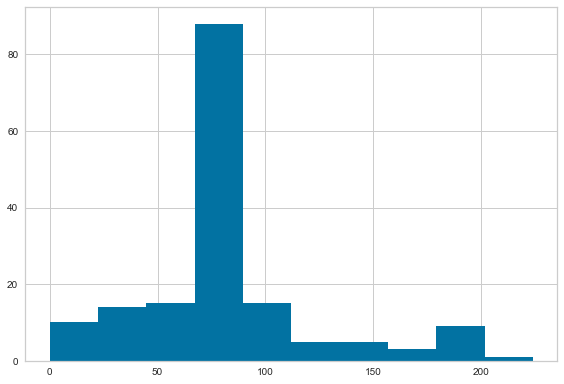

In [21]:
## Feature with the most outliers
df_data['Iron'].hist()

High frequency of the values near mean value results in considering extreme value to be considered as the outlier

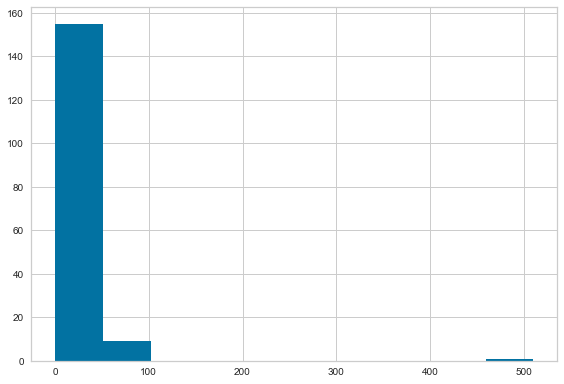

In [22]:
df_data['Packs of cigarets per year'].hist()

On higher side, there is a patient with ~500 cigarette packs per year which is an outlier and can be treated. In this case, we will cap the highest value to 99% percentile value.

In [23]:
# Handle Outliers: 4 methods to handle outliers
#         mean       : Points beyond three time standard deviation from
#                      mean are outliers
#         median     : Points beyond 1.5 times IQR(interquartile range)
#                      from median are outliers
#         actual     : Points beyond specified values are outliers
#         percentile : Points beyond specified percentage are outliers
#                      (default 95% and 5%)

df_data['Oultier_capped_Packs of cigarets per year']=dp.outliers.handle_outliers(df_data['Packs of cigarets per year'],method='percentile',percentile_limit=(0,0.99))

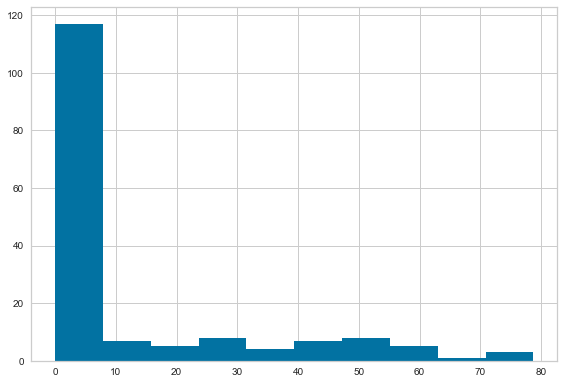

In [24]:
df_data['Oultier_capped_Packs of cigarets per year'].hist()

In [25]:
## EDA
an = eda.Analyser(data = df_data,y=config_file['target_column'])

In [26]:
x_vars=an.get_cat_columns()

In [27]:
joint_object = eda.JointPlot(df_data)
joint_plots = joint_object.get_plots(x_vars = x_vars, y_vars = ['Class Attribute'])

In [28]:
joint_plots['Diabetes']['Class Attribute']

:Bars   [Diabetes,Variable]   (value)

In [29]:
joint_plots['Alcohol']['Class Attribute']

:Bars   [Alcohol,Variable]   (value)

In [30]:
joint_plots[x_vars[1]]['Class Attribute']

:Bars   [Arterial Hypertension,Variable]   (value)

Patients without Arterial Hypertension have higher proportion of survival (40% vs 33%)

In [31]:
joint_plots[x_vars[2]]['Class Attribute']

:Bars   [Ascites degree,Variable]   (value)

Patients with Chronic Renal Insufficiency have 50% proportion of survival

In [32]:
joint_plots[x_vars[3]]['Class Attribute']

:Bars   [Chronic Renal Insufficiency,Variable]   (value)

Patients without Cirrhosis have higher proportion of survival

In [33]:
joint_plots[x_vars[4]]['Class Attribute']

:Bars   [Cirrhosis,Variable]   (value)

Patient with Diabetes had higher proportion of survival compared to patients without Diabetes

In [34]:
joint_plots[x_vars[6]]['Class Attribute']

:Bars   [Encephalopathy degree,Variable]   (value)

Patients with or without Esophageal Varices have almost same proportion of survival

In [35]:
joint_plots[x_vars[7]]['Class Attribute']

:Bars   [Endemic Countries,Variable]   (value)

Male have higher proportion of survival compared to Female

In [36]:
joint_plots[x_vars[8]]['Class Attribute']

:Bars   [Esophageal Varices,Variable]   (value)

In [37]:
joint_plots[x_vars[9]]['Class Attribute']

:Bars   [Gender,Variable]   (value)

Patients with Hepatitis B Core Antibody have higher proportion of survival

In [38]:
joint_plots[x_vars[10]]['Class Attribute']

:Bars   [Hemochromatosis,Variable]   (value)

Patients without Hepatitis B Surface Antigen have higher proportion of survival

In [39]:
joint_plots[x_vars[11]]['Class Attribute']

:Bars   [Hepatitis B Core Antibody,Variable]   (value)

In [40]:
joint_plots[x_vars[12]]['Class Attribute']

:Bars   [Hepatitis B Surface Antigen,Variable]   (value)

Patients without Hepatitis C Virus Antibody have higher proportion of survival

In [41]:
joint_plots[x_vars[13]]['Class Attribute']

:Bars   [Hepatitis B e Antigen,Variable]   (value)

In [42]:
joint_plots[x_vars[14]]['Class Attribute']

:Bars   [Hepatitis C Virus Antibody,Variable]   (value)

Patients with Liver Metastasis have lower proportion of survivals

In [43]:
joint_plots[x_vars[15]]['Class Attribute']

:Bars   [Human Immunodeficiency Virus,Variable]   (value)

In [44]:
joint_plots[x_vars[16]]['Class Attribute']

:Bars   [Liver Metastasis,Variable]   (value)

In [45]:
joint_plots[x_vars[17]]['Class Attribute']

:Bars   [Nonalcoholic Steatohepatitis,Variable]   (value)

Patients with Portal Hypertension have lower proportion of survivals

In [46]:
joint_plots[x_vars[18]]['Class Attribute']

:Bars   [Obesity,Variable]   (value)

Patients with Portal Vein Thrombosis have lower proportion of survivals

In [47]:
joint_plots[x_vars[19]]['Class Attribute']

:Bars   [Performance Status,Variable]   (value)

In [48]:
joint_plots[x_vars[20]]['Class Attribute']

:Bars   [Portal Hypertension,Variable]   (value)

Patients with Smoking habit have lower proportion of survival

In [49]:
joint_plots[x_vars[21]]['Class Attribute']

:Bars   [Portal Vein Thrombosis,Variable]   (value)

In [50]:
joint_plots[x_vars[22]]['Class Attribute']

:Bars   [Radiological Hallmark,Variable]   (value)

Patients without Symptons have low proportion of Survival

### Correlation Plot

In [51]:
num_cols = df_data._get_numeric_data().columns

x = an.correlation_table()
x[(x['Variable 1'].isin(num_cols)) & (x['Abs Coer Coef']>0.7)]

Started running correlation_table
Finished running correlation_table
Time taken to run correlation_table is 0 seconds


Variable 1                    Variable 2  Coer Coef  \
0    Direct Bilirubin (mg/dL)        Total Bilirubin(mg/dL)   0.970185   
1  Alanine transaminase (U/L)  Aspartate transaminase (U/L)   0.728180   

   Abs Coer Coef  
0       0.970185  
1       0.728180

Since there is high correlation between Variable 1 and Variable 2 shown above, one value of the pair can be removed from the dataset.

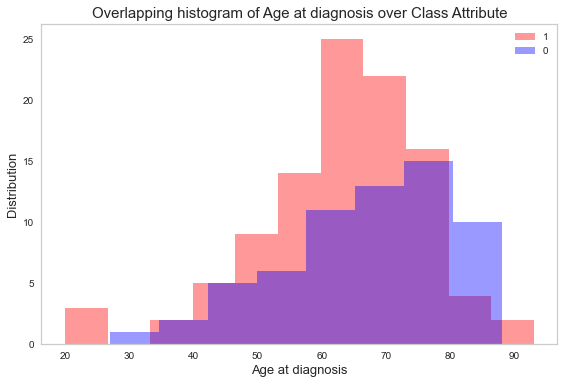

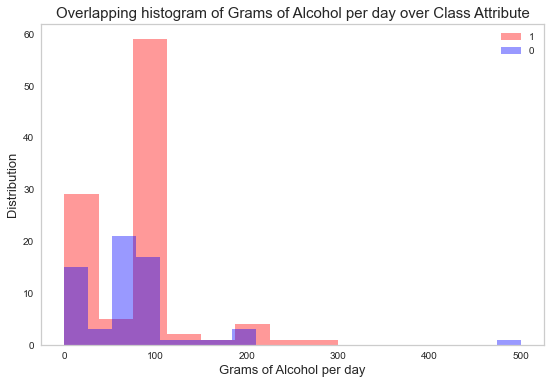

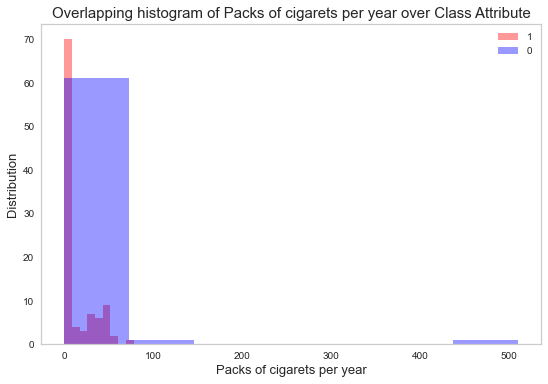

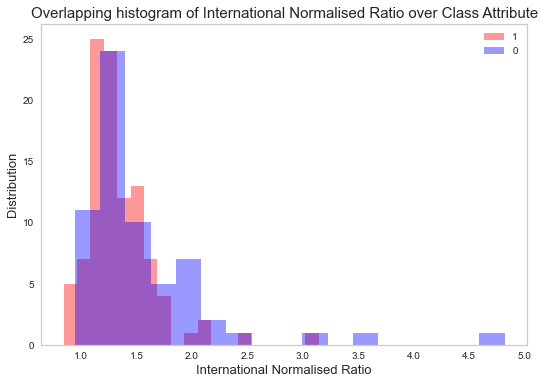

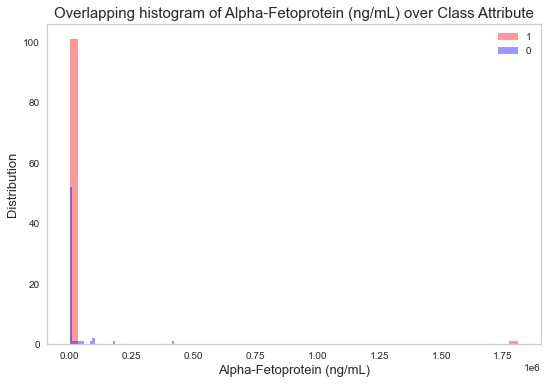

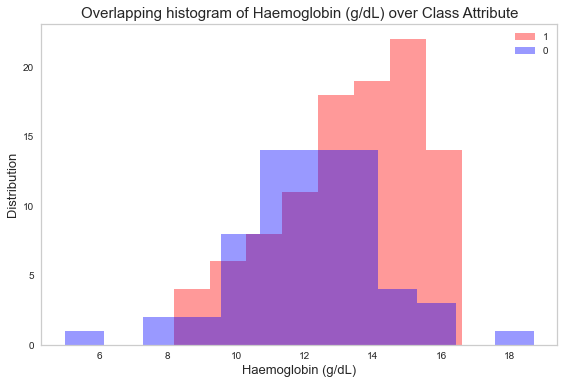

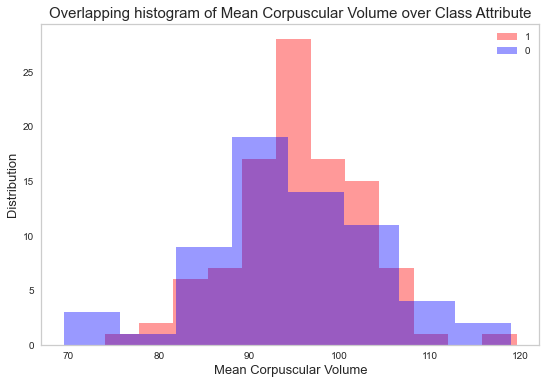

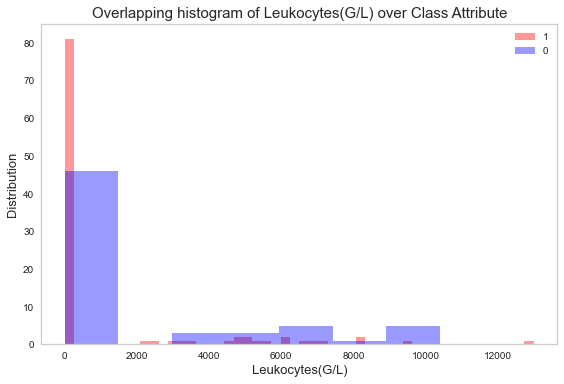

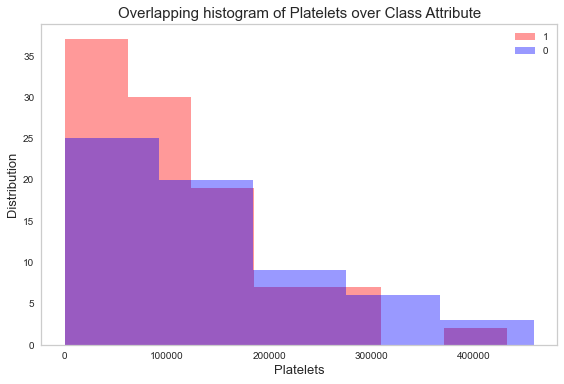

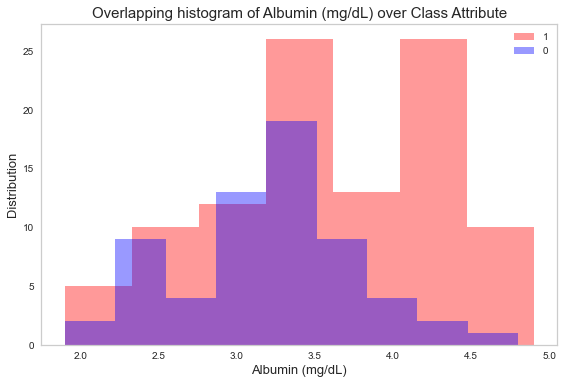

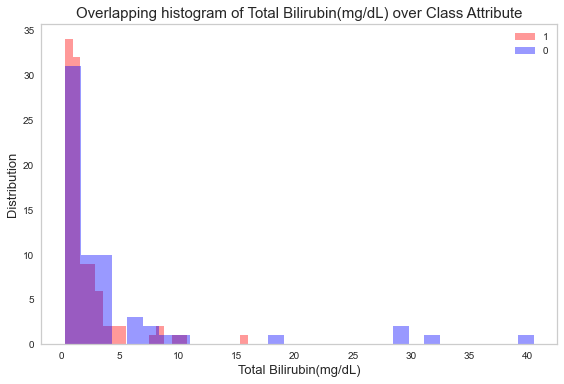

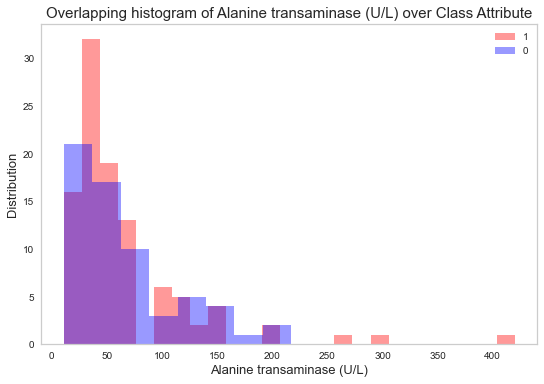

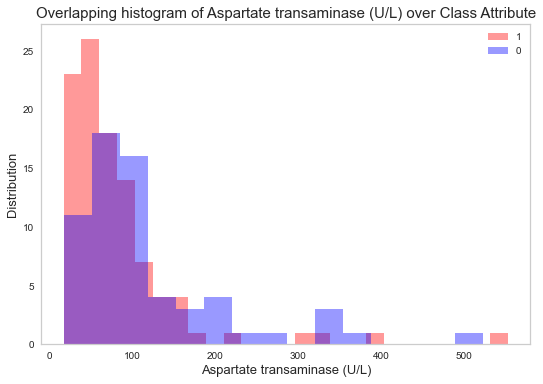

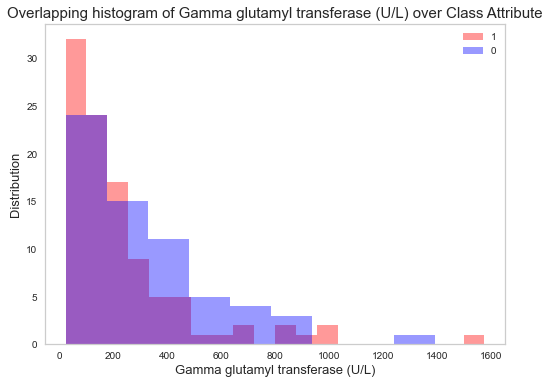

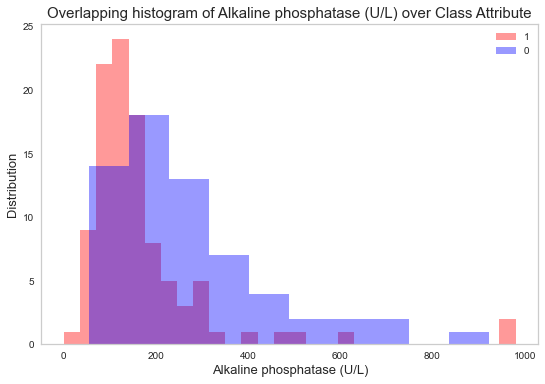

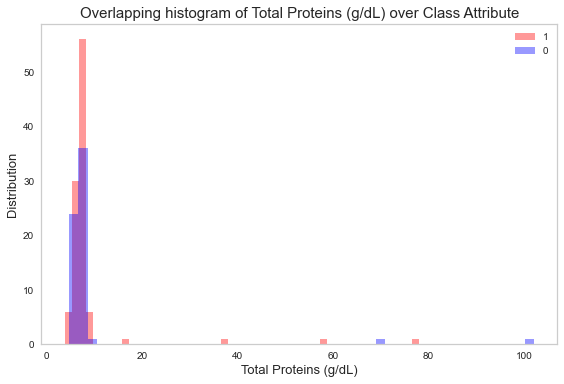

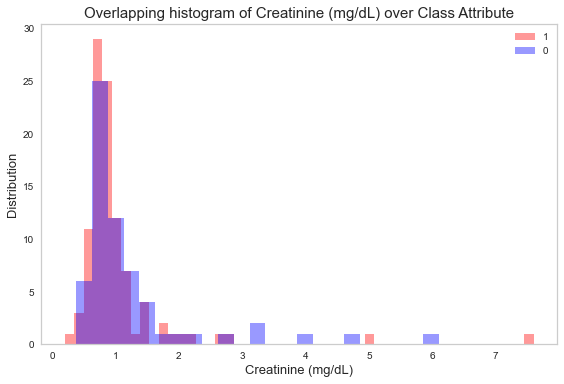

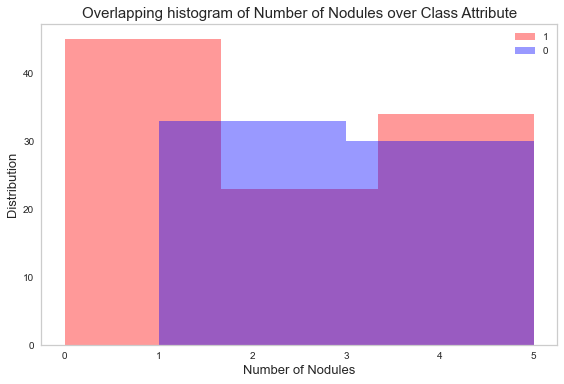

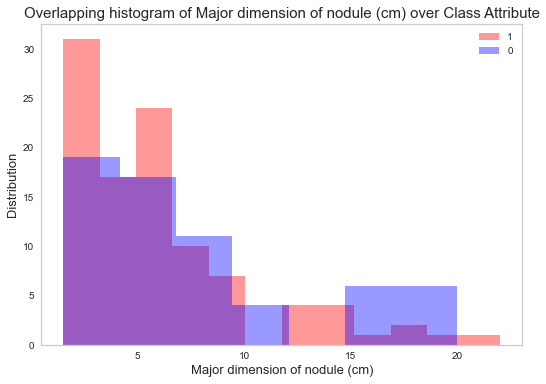

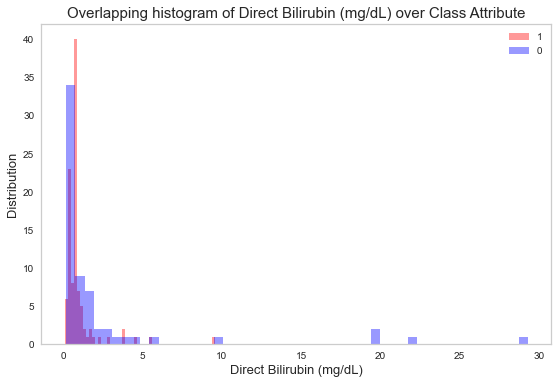

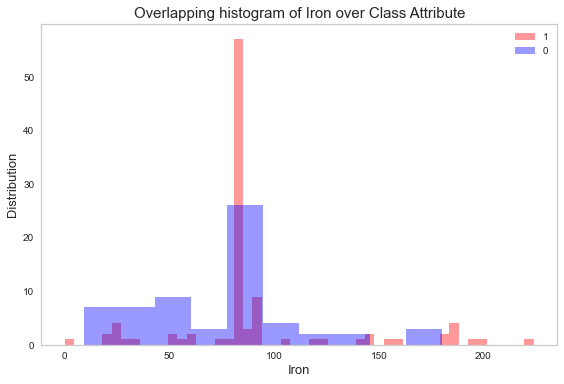

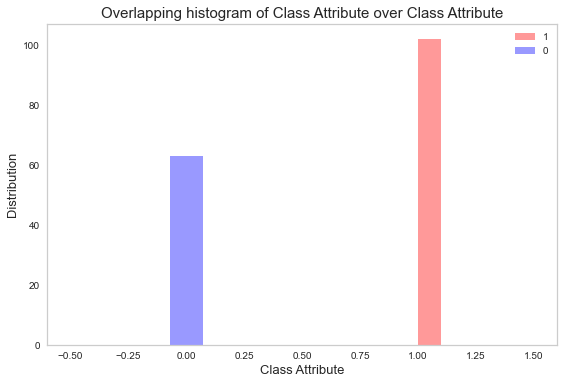

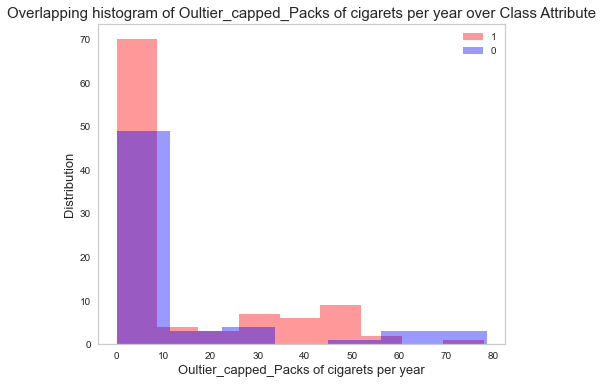

In [52]:
for i in df_data._get_numeric_data().columns:
    eda.overlapping_histograms(df_data,i,'Class Attribute')


1) Patients having mean corpuscular volume between 75 to 90 have more survivals  
2) Patients with platelets less than 100,000 have higher non-survivals

Based on correlation coefficient we will remove, Direct Bilirubin (mg/dL) and Alanine transaminase (U/L)

In [53]:
df_data.drop(['Alanine transaminase (U/L)','Direct Bilirubin (mg/dL)'],axis=1,inplace=True)

### Encoding of categorical variables
#### Three types of encodings are available 
One Hot  
Label Encode   
Target Encoding  
Since here we have all the variables of the numeric type (or with binary values) they will be treated like one hot encoded values



### Generating HTML Reports

In [54]:
an = eda.Analyser(data = df_data,y=config_file['target_column'])

In [55]:
an.health_analysis(save_as='.html')

Started running health_analysis
Started running data_health
Started running duplicate_columns
processing set of - ['Symptoms ', 'Hepatitis B Surface Antigen', 'Hepatitis B e Antigen', 'Hepatitis B Core Antibody', 'Hepatitis C Virus Antibody', 'Endemic Countries', 'Arterial Hypertension', 'Chronic Renal Insufficiency', 'Human Immunodeficiency Virus', 'Nonalcoholic Steatohepatitis', 'Splenomegaly', 'Portal Hypertension', 'Portal Vein Thrombosis', 'Liver Metastasis', 'Performance Status']
processing set of - ['Gender', 'Alcohol', 'Cirrhosis', 'Smoking', 'Diabetes', 'Hemochromatosis', 'Esophageal Varices', 'Radiological Hallmark', 'Encephalopathy degree', 'Ascites degree']
Finished running duplicate_columns
Time taken to run duplicate_columns is 0 seconds
Finished running data_health
Time taken to run data_health is 0 seconds
Started running missing_plot
Finished running missing_plot
Time taken to run missing_plot is 0 seconds
Started running missing_value_summary
Finished running missing_

{'health_plot': :Layout
    .Bars.I   :Bars   [index,Variable]   (value)
    .Bars.II  :Bars   [index,Variable]   (value)
    .Bars.III :Bars   [index,Variable]   (value)
    .Bars.IV  :Bars   [index,Variable]   (value),
 'missing_plot': :Bars   [index]   (0),
 'missing_value_summary': 'No Missing Values',
 'duplicate_columns': 'No duplicate variables',
 'outliers_in_features':                                            < (mean-3*std)  > (mean+3*std)  \
 feature                                                                     
 Age at diagnosis                                        2               0   
 Alkaline phosphatase (U/L)                              0               3   
 Alpha-Fetoprotein (ng/mL)                               0               1   
 Aspartate transaminase (U/L)                            0               4   
 Creatinine (mg/dL)                                      0               5   
 Gamma glutamyl transferase (U/L)                        0               2

In [56]:
an.feature_analysis(save_as='.html')

Started running feature_analysis
Started running numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running numeric_summary
Time taken to run numeric_summary is 0 seconds
Started running non_numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running non_numeric_summary
Time taken to run non_numeric_summary is 0 seconds
Started running density_plots
Finished running density_plots
Time taken to run density_plots is 0 seconds
Started running percentile_plots
Finished running percentile_plots
Time taken to run percentile_plots is 0 seconds
Started running non_numeric_frequency_plot
Finished running non_numeric_frequency_plot
Time taken to run non_numeric_frequency_plot is 0 seconds
Started running feature_normality
Finished running feature_normality
Time taken to run feature_normality is 0 seconds
Finished running 

{'summary_stats': {'numeric_variables': [<tigerml.dataframe.dataframe.DataFrame at 0x1e2c2ee1430>],
  'non_numeric_variables': [<tigerml.dataframe.dataframe.DataFrame at 0x1e2c4a03c70>]},
 'distributions': {'numeric_variables': {'Age at diagnosis': [:Layout
       .Distribution.I :Distribution   [Age at diagnosis]   (Density)
       .Table.I        :Table   [count,mean,std,min,25%,50%,75%,max],
    :Layout
       .Bars.Age_at_diagnosis :Bars   [index]   (Age at diagnosis)
       .Table.I               :Table   [min,0.2%,0.4%,0.6%,0.8%,1%]
       .Table.II              :Table   [99%,99.2%,99.4%,99.6%,99.8%]],
   'Albumin (mg/dL)': [:Layout
       .Distribution.I :Distribution   [Albumin (mg/dL)]   (Density)
       .Table.I        :Table   [count,mean,std,min,25%,50%,75%,max],
    :Layout
       .Bars.Albumin_left_parenthesis_mg_over_dL_right_parenthesis :Bars   [index]   (Albumin (mg/dL))
       .Table.I                                                    :Table   [min,0.2%,0.4%,0.6%,0.8

Started running preprocess_data
Cleaning data
No missing values
No Infinity values
Have 1 boolean variables. Converting False to 0 and True to 1
Encoding categorical variables with default settings which will not be ideal. Processing these variables manually is highly recommended.
Radiological Hallmark has levels with less than 3 (2.0%) values. Target encoding in such cases is not recommended.
Chronic Renal Insufficiency has levels with less than 3 (2.0%) values. Target encoding in such cases is not recommended.
Hepatitis B e Antigen has levels with less than 3 (2.0%) values. Target encoding in such cases is not recommended.
Encephalopathy degree has levels with less than 3 (2.0%) values. Target encoding in such cases is not recommended.
Ascites degree has levels with less than 3 (2.0%) values. Target encoding in such cases is not recommended.
Finished running preprocess_data
Time taken to run preprocess_data is 1 seconds
Started running get_feature_scores
Finished running get_feature_

{'Class Attribute': {'feature_scores': {'feature_correlation': :Bars   [index]   (Pearson_correlation_with_Target)},
  'feature_importances': {'from_model': :Bars   [index]   (importance)},
  'pca_analysis': {'pca_projection': :DynamicMap   []
      :RGB   [PC1,PC2]   (R,G,B,A),
   'correlation_with_dimension_2 (Y)': :Bars   [index]   (Pearson_correlation_with_Target),
   'correlation_with_dimension_1 (X)': :Bars   [index]   (Pearson_correlation_with_Target)}}}

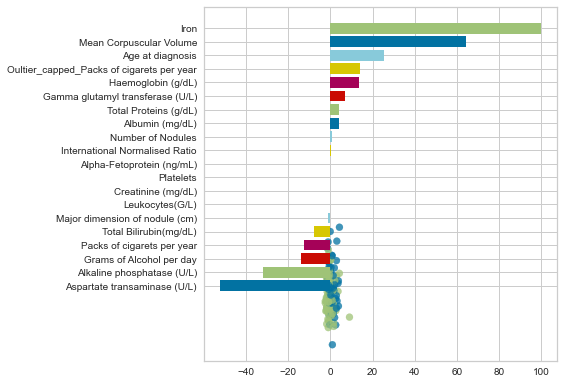

In [57]:
an.key_drivers(save_as='.html')

#### Cleaning columns names

### Splitting dataset into train and test dataset

In [58]:
x_train, x_test, y_train, y_test = dp.prep_data(data = df_data, dv_name = config_file['target_column'], 
                                             train_size = config_file['train_ratio'], remove_outliers = None, 
                                             random_state = config_file['seed'])

Cleaning data
Dropped 0 rows with missing values.
No Infinity values
Have 1 boolean variables. Converting False to 0 and True to 1
Encoding categorical variables with default settings which will not be ideal. Processing these variables manually is highly recommended.
Radiological Hallmark has levels with less than 3 (2.0%) values. Target encoding in such cases is not recommended.
Chronic Renal Insufficiency has levels with less than 3 (2.0%) values. Target encoding in such cases is not recommended.
Hepatitis B e Antigen has levels with less than 3 (2.0%) values. Target encoding in such cases is not recommended.
Encephalopathy degree has levels with less than 3 (2.0%) values. Target encoding in such cases is not recommended.
Ascites degree has levels with less than 3 (2.0%) values. Target encoding in such cases is not recommended.


### Feature Selection

In [59]:
features, df_feature_sel_metrics = fs.select_features(x_train, y_train, config_file)

selected features: ['Albumin (mg/dL)', 'Iron', 'Major dimension of nodule (cm)', 'Total Bilirubin(mg/dL)']


In [60]:
df_feature_sel_metrics.head()

feature_names avg_score
4  (Albumin (mg/dL), Iron, Major dimension of nod...  0.144082
5  (Albumin (mg/dL), Aspartate transaminase (U/L)...  0.139365
3  (Albumin (mg/dL), Major dimension of nodule (c...  0.136313
6  (Age at diagnosis, Albumin (mg/dL), Aspartate ...  0.134747
7  (Age at diagnosis, Albumin (mg/dL), Aspartate ...  0.124289

In [61]:
x_train = x_train[features]
x_test = x_test[features]

### Identifying the best fit model


The below code with iterate through the estimators present in the estimators.yml file and select the best model with the best parameters.

In [62]:
best_fit = model_gen.train_model(file_path, x_train, y_train)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=0.7, n_estimators=100 ..............................
[CV]  max_features=0.7, n_estimators=100, score=(train=1.000, test=0.815), total=   0.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] max_features=0.7, n_estimators=100 ..............................
[CV]  max_features=0.7, n_estimators=100, score=(train=1.000, test=0.741), total=   0.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[CV] max_features=0.7, n_estimators=100 ..............................
[CV]  max_features=0.7, n_estimators=100, score=(train=1.000, test=0.615), total=   0.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[CV] max_features=0.7, n_estimators=100 ..............................
[CV]  max_

[CV]  C=0.5, penalty=l2, score=(train=0.717, test=0.615), total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] C=0.5, penalty=l2 ...............................................
[CV]  C=0.5, penalty=l2, score=(train=0.717, test=0.615), total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[CV] C=0.5, penalty=l2 ...............................................
[CV]  C=0.5, penalty=l2, score=(train=0.717, test=0.654), total=   0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV]  C=1.0, penalty=l2, score=(train=0.686, test=0.815), total=   0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV]  C=1.0, penalty=l2, score=(train=0.705, test=0.778), total=   0.0s
[Parallel(n_jobs=1)]: Done   7 out o

In [63]:
best_fit

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

best_fit is the selected model out of all the estimators mentioned in the estimators.yml file

### Model Evaluation

More information on the ClassificationReport is availabe here: https://tigerrepository.github.io/TigerML/build/html/api/model_eval.html#tigerml.model_eval.ClassificationReport

In [64]:
classifier = model_eval.ClassificationReport(best_fit)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)


In [65]:
classifier.model.predict_proba(x_train)

array([[0.22139622, 0.77860378],
       [0.29023144, 0.70976856],
       [0.13137713, 0.86862287],
       [0.14263801, 0.85736199],
       [0.22957895, 0.77042105],
       [0.20982197, 0.79017803],
       [0.28657249, 0.71342751],
       [0.429743  , 0.570257  ],
       [0.18181329, 0.81818671],
       [0.61666683, 0.38333317],
       [0.43191323, 0.56808677],
       [0.63437026, 0.36562974],
       [0.28499417, 0.71500583],
       [0.05403601, 0.94596399],
       [0.36448607, 0.63551393],
       [0.24639162, 0.75360838],
       [0.98728723, 0.01271277],
       [0.62757891, 0.37242109],
       [0.21431687, 0.78568313],
       [0.25525648, 0.74474352],
       [0.10877872, 0.89122128],
       [0.70573767, 0.29426233],
       [0.43365588, 0.56634412],
       [0.71461334, 0.28538666],
       [0.08007242, 0.91992758],
       [0.08367266, 0.91632734],
       [0.86342031, 0.13657969],
       [0.13174603, 0.86825397],
       [0.40350047, 0.59649953],
       [0.23423457, 0.76576543],
       [0.

:Overlay
   .Curve.Precision          :Curve   [threshold]   (precision)
   .Curve.Recall             :Curve   [threshold]   (recall)
   .Curve.F1_score           :Curve   [threshold]   (f1_score)
   .Curve.Percent_of_Class_1 :Curve   [threshold]   (% of Class 1)

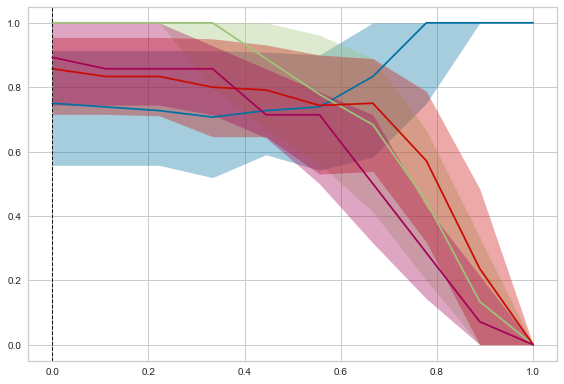

In [66]:
classifier.evaluator.discrimination_threshold()

In [67]:
classifier.model.predict(x_train)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1])

In [68]:
classifier.model.predict_proba(x_test)

array([[0.58762348, 0.41237652],
       [0.29976626, 0.70023374],
       [0.57244719, 0.42755281],
       [0.63091331, 0.36908669],
       [0.33117348, 0.66882652],
       [0.529561  , 0.470439  ],
       [0.79887343, 0.20112657],
       [0.56323675, 0.43676325],
       [0.27055413, 0.72944587],
       [0.98082017, 0.01917983],
       [0.44627882, 0.55372118],
       [0.21984298, 0.78015702],
       [0.5185913 , 0.4814087 ],
       [0.57137817, 0.42862183],
       [0.16907627, 0.83092373],
       [0.47728768, 0.52271232],
       [0.95946647, 0.04053353],
       [0.22480692, 0.77519308],
       [0.23094232, 0.76905768],
       [0.61685089, 0.38314911],
       [0.16579384, 0.83420616],
       [0.26364451, 0.73635549],
       [0.31746312, 0.68253688],
       [0.2132903 , 0.7867097 ],
       [0.1481418 , 0.8518582 ],
       [0.54120109, 0.45879891],
       [0.07021777, 0.92978223],
       [0.69058769, 0.30941231],
       [0.23772584, 0.76227416],
       [0.47511186, 0.52488814],
       [0.

In [69]:
classifier.model.predict(x_test)

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0])

:Curve   [False Positive Rate]   (True Positive Rate)

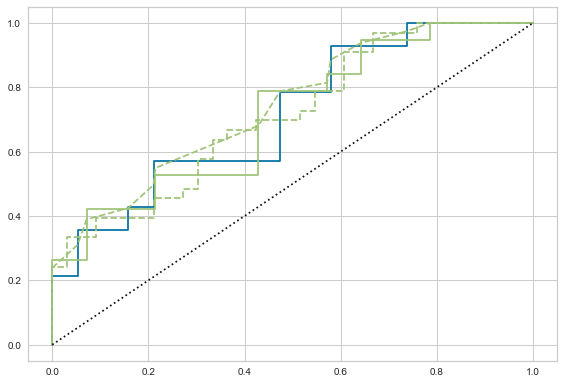

In [70]:
classifier.evaluator.roc_curve()

In [71]:
classifier.evaluator.confusion_matrix()

dataset          train                    test            
metric     predicted_0 predicted_1 predicted_0 predicted_1
true_label                                                
0                   23          26           8           6
1                   11          72           6          13

### Generating HTML Report

In [72]:
classifier.get_report()

6 instances are false positives
6 instances are false negatives


### Confusion Matrix component analysis

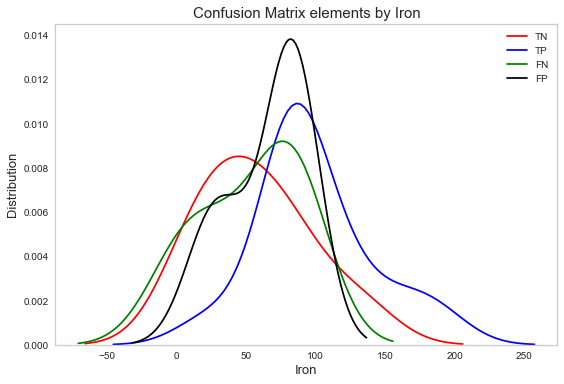

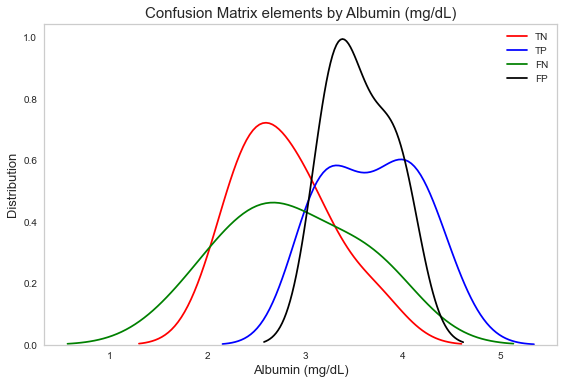

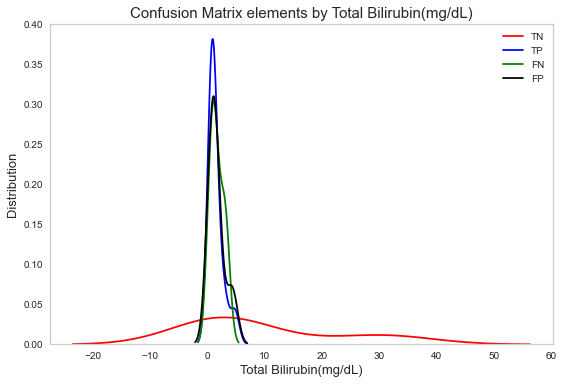

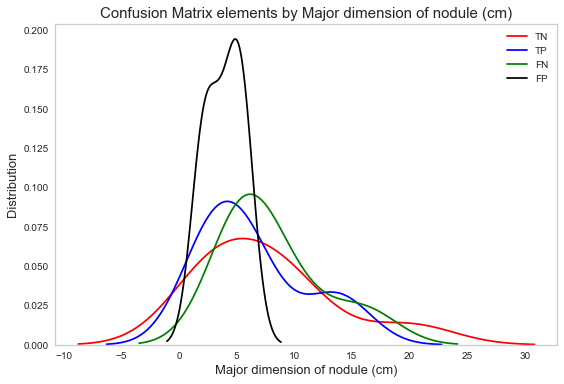

In [73]:
x_eval = x_test.copy()
x_eval['prediction'] = best_fit.predict(x_eval)
x_eval['actuals'] = y_test.reset_index(drop = True).iloc[:,0].values

eda.confusion_matrix_by_feature(x_eval, 'actuals', 'prediction',col_idv='Iron',categorical=False)
eda.confusion_matrix_by_feature(x_eval, 'actuals', 'prediction',col_idv='Albumin (mg/dL)',categorical=False)
eda.confusion_matrix_by_feature(x_eval, 'actuals', 'prediction',col_idv='Total Bilirubin(mg/dL)',categorical=False)
eda.confusion_matrix_by_feature(x_eval, 'actuals', 'prediction',col_idv='Major dimension of nodule (cm)',categorical=False)


The value indicates the index as a ratio of proportion of (TN/TP/FN/FP) in the class and proportion of TN/TP/FN/FP overall. For example, class 0 is 80% of the entire population but it is 20% in FP. So the index is 25.

Here value = 0 means no value presents in that class for that metric. So, 0 is desirable for FN and FP columns. Value = 100 indicate equal representation in both population and TN/TP/FN/FP.

We can tune the features and class where the value is much higer than 100.

For continuous variables, we see that in between certain values the TN/TP value below FP/FN indicating that in those range some tuning is required.